In [11]:
import sys, os
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import quad, nquad
from sklearn.preprocessing import normalize
from sktree.tree import DecisionTreeClassifier
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import entropy

import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.stats import gamma
from simulations import *
from sklearn import metrics

Dimension4
MI0.5093526712592461
pAUC 0.9216347242105263
S@98 0.79673
Dimension8
MI0.5661754426849267
pAUC 0.9581882621052631
S@98 0.89305
Dimension16
MI0.6067848619939022
pAUC 0.9790825678947368
S@98 0.94948
Dimension32
MI0.6341988032680753
pAUC 0.9898535873684211
S@98 0.97663
Dimension64
MI0.6535003129079748
pAUC 0.9952286121052631
S@98 0.99048
Dimension128


/Users/baiyuxin/anaconda3/envs/might/lib/python3.11/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(cov_object.whiten(dev)), axis=-1)
/Users/baiyuxin/anaconda3/envs/might/lib/python3.11/site-packages/scipy/stats/_multivariate.py:860: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logpdf(x))


MI0.665986023413212
pAUC 0.9975511294736842
S@98 0.99563
Dimension256


KeyboardInterrupt: 

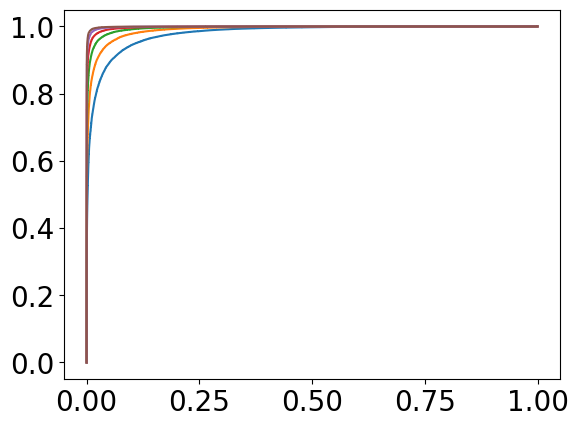

In [7]:
n = 100000
MIs = []
pAUCs = []
tprs = []
DIMENSIONS = [2**i for i in range(2, 9)]
# DIMENSIONS = [i for i in range(2, 100,2)]
for p in DIMENSIONS:
    print("Dimension" + str(p))
    mu_class0 = np.array([1/np.sqrt(i+1) for i in range(p)])
    mu_class1 = -mu_class0
    sig = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig,allow_singular=True)
    pdf_class1 = multivariate_normal(mean = mu_class1, cov = sig,allow_singular=True)
    p_class0 = 0.5
    p_class1 = 0.5
    x_1 = pdf_class0.rvs(size = n)
    x_2 = pdf_class1.rvs(size = n)
    x = np.vstack((x_1,x_2))
    y = np.array([0]*n+[1]*n).reshape(-1,1)


    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1 = np.nan_to_num(pdf_class1.pdf(x))


    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    plt.plot(fpr,tpr)
    tpr_s = np.max(tpr[np.round(fpr, 3)==0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)


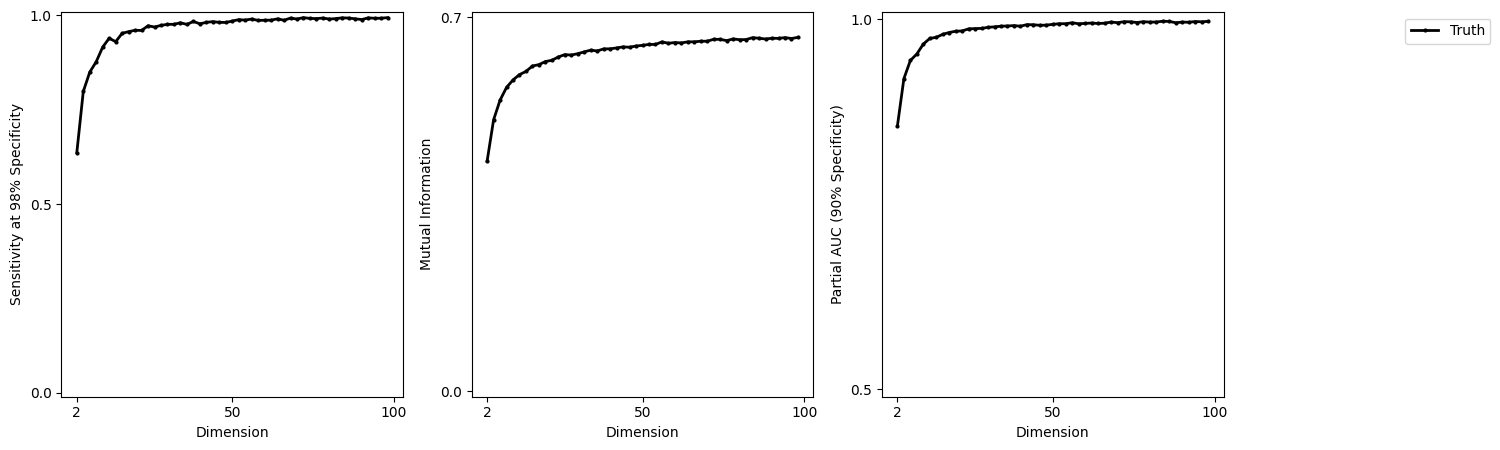

In [14]:
fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((-0.01,1.01))
axs[0].set_yticks((0,0.5,1))
axs[0].set_xticks((2,50,100))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((2,50,100))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((2,50,100))

axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

In [8]:
n_jobs = -1
test_size = 0.2
n_estimators = 500

### Calculate one dimention posterior with max_features = all, depth = 1
clf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=0.3,
        bootstrap= False,
        tree_estimator=DecisionTreeClassifier(),
        # max_depth = 1,
        honest_fraction=0.5,
        n_jobs=n_jobs,

    ),
    test_size=test_size,
    # permute_per_tree=True,
    sample_dataset_per_tree=False,
    stratify = True
)



In [9]:
def statistcs_MIGHT(clf,n=100,p=4096,metric = 'mi',reps = 1):
    clf.reset()
    mu_class0 = np.array([1/np.sqrt(i+1) for i in range(p) ])
    # print(mu_class0)
    mu_class1 = -mu_class0
    sig = np.identity(p)
    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig,allow_singular=True)
    pdf_class1 = multivariate_normal(mean = mu_class1, cov = sig,allow_singular=True)
    x_1 = pdf_class0.rvs(size = n)
    x_2 = pdf_class1.rvs(size = n)
    x = np.vstack((x_1,x_2))
    y = np.array([0]*n+[1]*n).reshape(-1,1)

    if metric == 'auc':
        stats,pos,samples = clf.statistic(x, y, metric=metric, return_posteriors=True,max_fpr = 0.1)
    else:
        stats,pos,samples = clf.statistic(x, y, metric=metric,return_posteriors=True)
    clf.reset()
    POS = pos[:,:,0].reshape((n_estimators,2*n))
    print(pos.shape)

    # np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/FigS8/Posterior/Posterior_SampleSize_new_sim_pertree_{}_{}_{}_{}.csv".format(metric,n,p, reps), POS, delimiter=",")
    # np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/FigS8/Posterior/Samples_SampleSize_new_sim_pertree_{}_{}_{}_{}.csv".format(metric,n,p,reps), samples, delimiter=",")
    # np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/FigS8/Posterior/Posterior_Dimension_{}_{}_{}_{}_{}.csv".format(sim,metric,n,p,reps), POS, delimiter=",")
    # np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/FigS8/Posterior/Samples_Dimension_{}_{}_{}_{}_{}.csv".format(sim,metric,n,p,reps), samples, delimiter=",")
    #POSs.append(POS)
    clf.reset()
    return stats

In [131]:
DIMENSIONS = [2**i for i in range(2, 8)]
print(len((DIMENSIONS)))
print(DIMENSIONS)
REPs = 50

6
[4, 8, 16, 32, 64, 128]


In [10]:
statistcs_MIGHT(clf,n = 1024,p = 100,metric = 'mi')

(500, 2048, 2)


0.25265751928124086

In [132]:
for i in range(0,REPs):
    print(i)
    stats = []
    for p_i in DIMENSIONS:
        stat = statistcs_MIGHT(clf,n = 512,p = p_i,metric = 'auc',reps = i)
        stats.append(stat)
        print(p_i,stat)
    print(stats)
    np.savetxt("/Users/baiyuxin/Desktop/JHU/NDD/Cancer/FigS8/MI/MI_Dimension_MIGHT_new_sim_pertree_{}.csv".format(i), stats, delimiter=",")

0
4 0.9154823704769737
8 0.939627396432977
16 0.9492123252467106
32 0.931789197419819
64 0.9101337633634868
128 0.9133742483038652
[0.9154823704769737, 0.939627396432977, 0.9492123252467106, 0.931789197419819, 0.9101337633634868, 0.9133742483038652]
1
4 0.9174619975842928
8 0.92340087890625
16 0.9259346409847862
32 0.9368446751644737
64 0.9148358796772205
128 0.8907711631373355
[0.9174619975842928, 0.92340087890625, 0.9259346409847862, 0.9368446751644737, 0.9148358796772205, 0.8907711631373355]
2
4 0.9068290308902138
8 0.9443576210423519
16 0.9353469045538652
32 0.916277433696546
64 0.9068089535361843
128 0.891261050575658
[0.9068290308902138, 0.9443576210423519, 0.9353469045538652, 0.916277433696546, 0.9068089535361843, 0.891261050575658]
3
4 0.8637751529091283
8 0.9330099005448191
16 0.916735197368421
32 0.9114950079666941
64 0.9116275185032895
128 0.9158317164370888
[0.8637751529091283, 0.9330099005448191, 0.916735197368421, 0.9114950079666941, 0.9116275185032895, 0.9158317164370888

(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
[0.8771908408717106, 0.9334556178042763, 0.9352706106085527, 0.9275609066611843, 0.9017173365542763, 0.9088327508223684]
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
[0.889269377055921, 0.94964599609375, 0.9310945209703947, 0.896497224506579, 0.8973485043174343, 0.8805477744654606]
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
[0.8803389699835527, 0.9331022563733553, 0.9359130859375, 0.9009463661595395, 0.908399079975329, 0.9006251284950658]
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
[0.9131373355263157, 0.9245573344983553, 0.9368928608141447, 0.9244127775493421, 0.9051545795641447, 0.9359291478207237]
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
[0.881077816611842, 0.8858642578125, 0.9353991056743421, 0.89715576171875, 0.9332307514391447, 0.9186626233552632]
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
[0.856776187294408, 0.9208309775904605, 0.9243806537828947, 0.9267256887335527, 0.9153378135279606, 0.917650724712171]
(512,)
(512,)
(512,)
(512,)
(512,)
(51

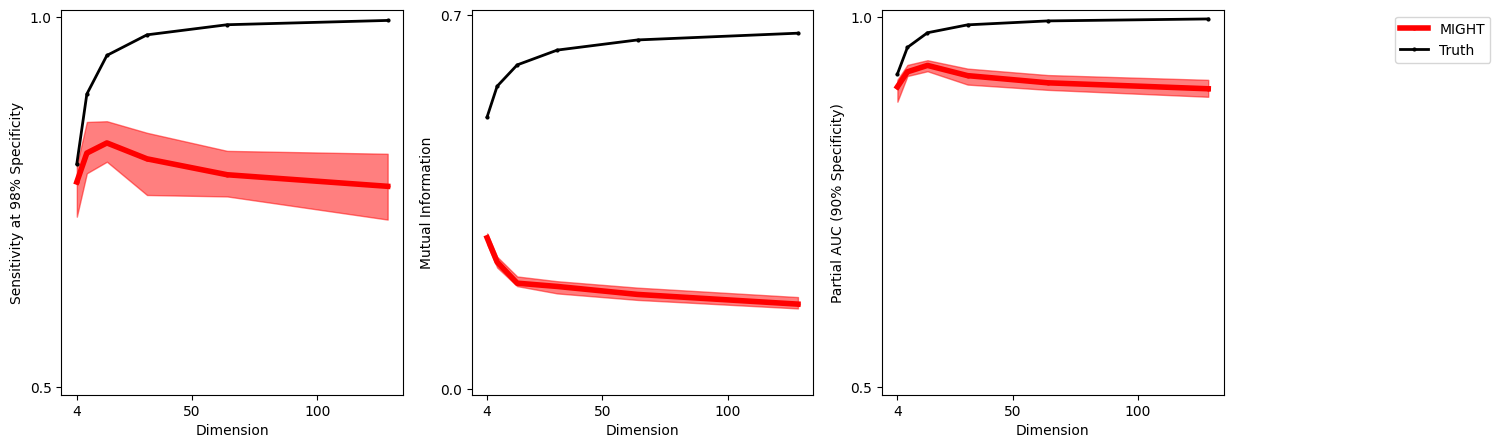

In [135]:
REPs = 50
metric = 'auc'
n = 256
STATS_S98_MIGHT = np.zeros((REPs,len(DIMENSIONS)))
STATS_MI_MIGHT = np.zeros((REPs,len(DIMENSIONS)))
STATS_pAUC_MIGHT = np.zeros((REPs,len(DIMENSIONS)))
for k in range(REPs):
    s98 = []
    MIs = []
    pAUCs= []
    for p in DIMENSIONS:
        pos = np.genfromtxt('/Users/baiyuxin/Desktop/JHU/NDD/Cancer/FigS8/Posterior/Posterior_SampleSize_new_sim_pertree_{}_{}_{}_{}.csv'.format(metric,n,p,k),delimiter=',')
        sam = np.genfromtxt('/Users/baiyuxin/Desktop/JHU/NDD/Cancer/FigS8/Posterior/Samples_SampleSize_new_sim_pertree_{}_{}_{}_{}.csv'.format(metric,n,p,k),delimiter=',')
        sample = [int(i) for i in sam]
        # print(sample)
        pos_test = pos[:,sample]
        posterior_forest_1 = np.nanmean(pos_test, axis=0)
        print(posterior_forest_1.shape)
        posterior_forest_0 = np.ones(posterior_forest_1.shape)-posterior_forest_1
        posterior_forest = np.hstack((posterior_forest_0.reshape(-1,1),posterior_forest_1.reshape(-1,1)))
        y = np.array([0]*n+[1]*n)
        y_test = y[sample]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, posterior_forest[:,1], pos_label=1,drop_intermediate = False)
        # plt.plot(fpr,tpr)
        if len(tpr[np.round(fpr, 3)==0.02]) == 0:
            s98.append(np.max(tpr[np.round(fpr, 2)==0.0]))
        else:
            s98.append(np.max(tpr[np.round(fpr, 3)==0.02]))
        stats_conen = np.mean(entropy(posterior_forest, base=np.exp(1), axis=1))
        prior_y = np.array([len(y_test)-np.sum(y_test),np.sum(y_test)])
        entropy_y = entropy(prior_y, base=np.exp(1))
        # print('entropy'+str(stats_conen))
        MI = entropy_y - stats_conen
        MIs.append(MI)
        pauc = roc_auc_score(y_test, posterior_forest[:,1], max_fpr=0.1)
        pAUCs.append(pauc)
        
    # print(s98)
    # print(MIs)
    print(pAUCs)

    STATS_S98_MIGHT[k,:] = s98
    STATS_MI_MIGHT[k,:] = MIs
    STATS_pAUC_MIGHT[k,:] = pAUCs

fig, axs = plt.subplots(1, 3,figsize=(15, 5))
median_MIGHT = np.quantile(STATS_S98_MIGHT, 0.5, axis=0)
mean_MIGHT = np.mean(STATS_S98_MIGHT,axis = 0)
q25_MIGHT = np.quantile(STATS_S98_MIGHT, 0.25, axis=0)
q75_MIGHT = np.quantile(STATS_S98_MIGHT, 0.75, axis=0)
axs[0].plot(DIMENSIONS,median_MIGHT,
                    'r',marker='o', markersize=2,label = 'MIGHT',linewidth =4)
axs[0].fill_between(DIMENSIONS,q25_MIGHT,q75_MIGHT,
                            alpha = 0.5,color ='red')

median_MIGHT = np.quantile(STATS_MI_MIGHT, 0.5, axis=0)
mean_MIGHT = np.mean(STATS_MI_MIGHT,axis = 0)
q25_MIGHT = np.quantile(STATS_MI_MIGHT, 0.25, axis=0)
q75_MIGHT = np.quantile(STATS_MI_MIGHT, 0.75, axis=0)
axs[1].plot(DIMENSIONS,median_MIGHT,
                    'r',marker='o', markersize=2,label = 'MIGHT',linewidth =4)
axs[1].fill_between(DIMENSIONS,q25_MIGHT,q75_MIGHT,
                            alpha = 0.5,color ='red')


median_MIGHT = np.quantile(STATS_pAUC_MIGHT, 0.5, axis=0)
mean_MIGHT = np.mean(STATS_pAUC_MIGHT,axis = 0)
q25_MIGHT = np.quantile(STATS_pAUC_MIGHT, 0.25, axis=0)
q75_MIGHT = np.quantile(STATS_pAUC_MIGHT, 0.75, axis=0)
axs[2].plot(DIMENSIONS,median_MIGHT,
                    'r',marker='o', markersize=2,label = 'MIGHT',linewidth =4)
axs[2].fill_between(DIMENSIONS,q25_MIGHT,q75_MIGHT,
                            alpha = 0.5,color ='red')



n = 1000000
MIs = []
pAUCs = []
tprs = []
# DIMENSIONS = [2**i for i in range(2, 10)]
# DIMENSIONS = [i for i in range(2, 100,2)]
for p in DIMENSIONS:
    print("Dimension" + str(p))
    mu_class0 = np.array([1/np.sqrt(i+1) for i in range(p)])
    mu_class1 = -mu_class0
    sig = np.identity(p)

    pdf_class0 = multivariate_normal(mean = mu_class0, cov = sig,allow_singular=True)
    pdf_class1 = multivariate_normal(mean = mu_class1, cov = sig,allow_singular=True)
    p_class0 = 0.5
    p_class1 = 0.5
    x_1 = pdf_class0.rvs(size = n)
    x_2 = pdf_class1.rvs(size = n)
    x = np.vstack((x_1,x_2))
    y = np.array([0]*n+[1]*n).reshape(-1,1)


    p_x_given_class0 = np.nan_to_num(pdf_class0.pdf(x))
    p_x_given_class1 = np.nan_to_num(pdf_class1.pdf(x))


    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1

    pos_class0 = np.array([p_x_given_class0[i]*p_class0/p_x[i] if p_x[i] != 0 else 0 for i in range(p_x.shape[0])]).reshape(-1,1)
    pos_class1 = np.ones(pos_class0.shape) - pos_class0

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    # print(posterior.shape)
    # posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # print('entropy'+str(stats_conen))
    MI = entropy_y - stats_conen
    print("MI"+str(MI))
    MIs.append(MI)
    # plt.scatter(x[:,0],x[:,-1],c = y,alpha = 0.3,s=2)
    # plt.show()
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    print('pAUC '+ str(pauc))
    pAUCs.append(pauc)

    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[np.round(fpr, 3)==0.02])
    print('S@98 '+ str(tpr_s))
    tprs.append(tpr_s)





axs[0].plot(DIMENSIONS,tprs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[0].set_ylabel('Sensitivity at 98% Specificity')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim((0.49,1.01))
axs[0].set_yticks((0.5,1))
axs[0].set_xticks((4,50,100))

axs[1].plot(DIMENSIONS,MIs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim((-0.01,0.71))
axs[1].set_yticks((0,0.7))
axs[1].set_xticks((4,50,100))

axs[2].plot(DIMENSIONS,pAUCs,
                    'black',marker='o', markersize=2,label = 'Truth',linewidth =2)
axs[2].set_ylabel('Partial AUC (90% Specificity)')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim((0.49,1.01))
axs[2].set_yticks((0.5,1))
axs[2].set_xticks((4,50,100))


axs[2].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

In [53]:
STATS_S98_MIGHT

array([[0.7265625 , 0.8125    , 0.72265625, 0.859375  , 0.78125   ,
        0.703125  ],
       [0.73046875, 0.8984375 , 0.87109375, 0.85546875, 0.80078125,
        0.70703125],
       [0.828125  , 0.8359375 , 0.80859375, 0.78515625, 0.8359375 ,
        0.74609375],
       [0.7734375 , 0.8515625 , 0.8515625 , 0.76953125, 0.8046875 ,
        0.6953125 ],
       [0.765625  , 0.8125    , 0.8125    , 0.77734375, 0.82421875,
        0.79296875],
       [0.71484375, 0.6953125 , 0.77734375, 0.81640625, 0.80859375,
        0.8515625 ],
       [0.78515625, 0.90234375, 0.82421875, 0.87109375, 0.74609375,
        0.6953125 ],
       [0.796875  , 0.8046875 , 0.8046875 , 0.7578125 , 0.7734375 ,
        0.7421875 ],
       [0.796875  , 0.8359375 , 0.80078125, 0.828125  , 0.81640625,
        0.76953125],
       [0.7890625 , 0.8671875 , 0.81640625, 0.8125    , 0.79296875,
        0.71484375],
       [0.78125   , 0.78515625, 0.890625  , 0.8359375 , 0.796875  ,
        0.82421875],
       [0.7421875 , 0